In [ ]:
#Importamos las librerías necesarias para esto
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class MLP(torch.nn.Module):
    """
    Multilayer perceptron (MLP) // Perceptríon Multicapa .

    Esta clase define una red neuronal feedforward con múltiples capas ocultas)
    lineales, funciones de activación tangente hiperbólica en  las capas ocultas
    y una salida lineal.

    Args:
        sizes (lista): Lista de enteros que especifica el número de neuronas en
        cada capa. El primer elemento debe coincidir con la dimensión de entrada
        y el último con la dimensión de salida.

    Atributos:
        capas (torch.nn.ModuleList): Lista que contiene las capas lineales del MLP.

    Métodos:
        forward(x): Realiza una pasada hacia adelante a través de la red MLP.

    Ejemplo:
        tamaños = [entrada_dim, oculta1_dim, oculta2_dim, salida_dim]
        mlp = MLP(tamaños)
        tensor_entrada = torch.tensor([...])
        salida = mlp(tensor_entrada)
    """
    def __init__(self,sizes):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        self.w0 = torch.nn.Parameter(data=torch.Tensor([10]), requires_grad=True)
        self.d = torch.nn.Parameter(data=torch.Tensor([1]), requires_grad=True)
        for i in range(len(sizes)-1):
            self.layers.append(torch.nn.Linear(sizes[i],sizes[i+1]))
    def forward(self,x):
        h = x
        for hidden in self.layers[:-1]:
            h = torch.tanh(hidden(h))
        output = self.layers[-1]
        y = output(h)
        return y

In [ ]:
d  = 2
w0 = 18
time = np.arange(0,5,0.01)
def oscilador(d,w0,t):
    l1 = -d + 1j * (w0**2-d**2)**0.5  # l+
    l2 = -d - 1j * (w0**2-d**2)**0.5  # l-
    A = -l2/(l1-l2)
    B = l1/(l1-l2)
    return np.real(A*np.exp(l1*t)+B*np.exp(l2*t))

def der_oscilador(d,w0,t): # derivada
    l1 = -d + 1j * (w0**2-d**2)**0.5  # l+
    l2 = -d - 1j * (w0**2-d**2)**0.5  # l-
    A = -l2/(l1-l2)
    B = l1/(l1-l2)
    return np.real(A*l1*np.exp(l1*t)+B*l2*np.exp(l2*t))

In [ ]:
t_data_pinn    = torch.linspace(0,1,200).view(-1,1) #Tiempos de los datos
y_data_pinn    = oscilador(d ,w0 ,t_data_pinn).view(-1,1) #Valores de los datos 'medidos'
t_physics = torch.linspace(0,1,200).view(-1,1).requires_grad_(True)

In [ ]:
#pinn = MLP([1,32,32,32,32,32,1])
optimizer_pinn = torch.optim.Adam(pinn.parameters(),lr=1e-3)

In [ ]:
pinn.w0

Parameter containing:
tensor([1.], requires_grad=True)

In [ ]:
iterations = 25000
l = 1e-4  #Lambda (cambié de 1 a 5 para mejor resultado en [0,1])
loss1_list = []
loss2_list = []

for epoch in range(iterations):
    optimizer_pinn.zero_grad()
    yh_pinn = pinn(t_data_pinn)
    loss1 = torch.mean((yh_pinn-y_data_pinn)**2)
    yhp_pinn = pinn(t_physics)
    #Computo de derivada
    dx  = torch.autograd.grad(yhp_pinn, t_physics, torch.ones_like(yhp_pinn), create_graph=True)[0]# computamos dy/dx
    dx2 = torch.autograd.grad(dx,  t_physics, torch.ones_like(dx),  create_graph=True)[0]# computamos d^2y/dx^2
    physics = dx2 + 2*pinn.d*dx + yhp_pinn*(pinn.w0**2) #Complete con la ecuación diferencial
    loss2 = l*torch.mean(physics**2) #Calculo el error cuadrático medio para la física

    loss = loss1 + loss2 #Se suma el error de la física con el de los datos
    loss.backward()
    optimizer_pinn.step()

    with torch.autograd.no_grad():
      print(epoch,loss1.item(), loss2.item(),"Traning Loss:",loss.data.item(), pinn.w0.item(), pinn.d.item())
      #loss1_list.append(loss1.detach().numpy())
      #loss2_list.append(loss2.detach().numpy())

Streaming output truncated to the last 5000 lines.
20000 7.375512723228894e-06 7.852327689761296e-05 Traning Loss: 8.589879143983126e-05 17.975122451782227 2.0199058055877686
20001 5.915834208281012e-06 8.134949166560546e-05 Traning Loss: 8.726532541913912e-05 17.97534942626953 2.0199203491210938
20002 7.630936124769505e-06 8.186462946468964e-05 Traning Loss: 8.949556649895385e-05 17.97555160522461 2.0199079513549805
20003 6.51306663712603e-06 8.711763075552881e-05 Traning Loss: 9.363069693790749e-05 17.975770950317383 2.019918203353882
20004 8.53865913086338e-06 9.176698222290725e-05 Traning Loss: 0.00010030563862528652 17.97595977783203 2.019904851913452
20005 7.899621778051369e-06 0.00010175212082685903 Traning Loss: 0.0001096517444238998 17.976173400878906 2.0199129581451416
20006 1.0665898116712924e-05 0.00011150733917020261 Traning Loss: 0.00012217323819641024 17.976350784301758 2.0198941230773926
20007 1.036519188346574e-05 0.00012828430044464767 Traning Loss: 0.0001386494986945

In [ ]:
t0 =  0
tf =  1
N  =  10000
test_time_pinn2 = torch.linspace(t0,tf,N).view(-1,1)
y_test_pinn2    = oscilador(d,w0,test_time_pinn2)   #Esta es la solución teórica
test_time_eval_pinn2 = test_time_pinn2.requires_grad_(True)
y_eval_pinn2 = pinn(test_time_eval_pinn2) #Evaluación de la red

Text(0, 0.5, '$\\dot x$')

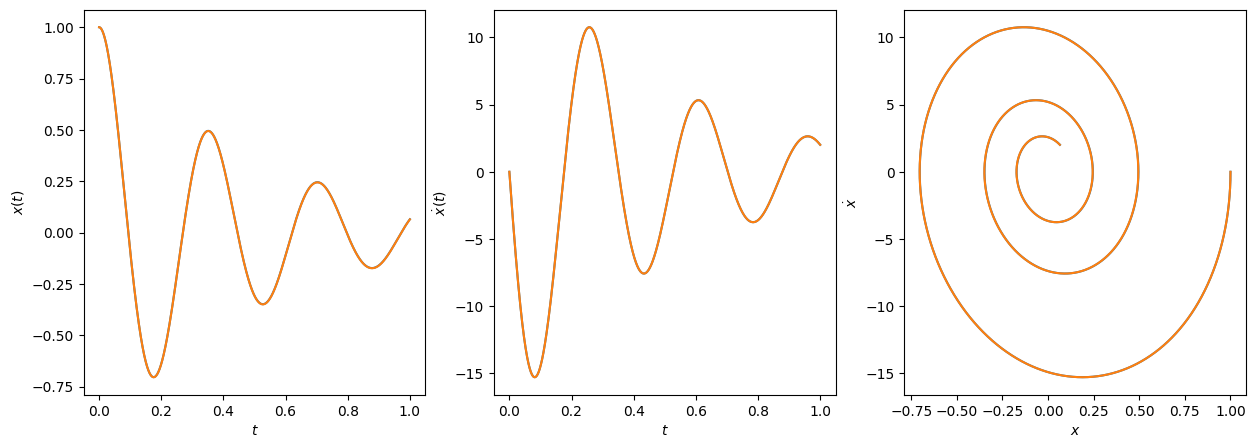

In [ ]:
# Derivadas
der_teo_pinn2 = der_oscilador(d,w0,test_time_pinn2.detach().numpy())
der_eval_pinn2 = torch.autograd.grad(y_eval_pinn2, test_time_pinn2, torch.ones_like(y_eval_pinn2), create_graph=True)[0]

plt.figure(figsize=(15,5))

ax1 = plt.subplot(131)
ax1.plot(test_time_pinn2.detach().numpy(),y_test_pinn2.detach().numpy())
ax1.plot(test_time_eval_pinn2.detach().numpy(),y_eval_pinn2.detach().numpy())
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$x(t)$')

ax2 = plt.subplot(132)
ax2.plot(test_time_pinn2.detach().numpy(),der_teo_pinn2)
ax2.plot(test_time_eval_pinn2.detach().numpy(),der_eval_pinn2.detach().numpy())
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'$\dot x(t)$')

ax3 = plt.subplot(133)
ax3.plot(y_test_pinn2.detach().numpy(),der_teo_pinn2)
ax3.plot(y_eval_pinn2.detach().numpy(),der_eval_pinn2.detach().numpy())
ax3.set_xlabel(r'$x$')
ax3.set_ylabel(r'$\dot x$')

Voy a escribir un integrador para la ecuación de Ginzburg Landau


$$\partial_t A = \mu A - V_g \partial_x A + \xi^2(1 + i c_1) \partial^2_x A - \ell_r^2(1 + i c_2)  A |A|^2 $$

In [ ]:
def evol(ru, iu, k, params, dt):
    # Evoluciona en el tiempo la PDE usando el método pseudoespectral y Runge-Kutta de segundo orden
    rf   = np.fft.rfft(ru)
    imf   = np.fft.rfft(iu)
    rft  = rf
    ift  = imf
    for ord in [2,1]:       # Bucle para el Runge-Kutta
        D   = dt/ord
        rfnl, ifnl = compute_abs(rf, imf)
        rfxx = -(k**2)*rf
        ifxx = -(k**2)*imf
        rfx = 1j*k*rf
        ifx = 1j*k*imf
        rf   =  rft + D*( params[0] * rf  - params[1] * rfx + params[2] * (rfxx - params[3] * ifxx) - params[4] * (rfnl - params[5]*rfnl))
        imf  =  ift + D*( params[0] * imf - params[1] * ifx + params[2] * (ifxx + params[3] * rfxx) - params[4] * (ifnl + params[5]*ifnl))
        rf[int(N/3):]  = 0    # Dealiasing
        imf[int(N/3):] = 0    # Dealiasing
    rout = np.fft.irfft(rf)
    iout = np.fft.irfft(imf)
    return rout, iout


def compute_abs(rf, imf):
  ru    = np.fft.irfft(rf)
  iu    = np.fft.irfft(imf)
  usq  = ru**2 + iu**2
  fsq  = np.fft.rfft(usq)
  fsq[int(N/3):] = 0
  usq = np.fft.irfft(fsq)
  rout = usq * ru
  iout = usq * iu
  rout = np.fft.rfft(rout)
  iout = np.fft.rfft(iout)
  return rout, iout

In [ ]:
N = 256
dt = 1e-5
steps = 0.3//dt
x = np.linspace(0,2*np.pi,N,endpoint=False) # Coordenada espacial en [0,2*pi)
k = np.arange(0,N/2+1)                      # Números de onda ordenados como en la FFT
mu = 0.5
vg = 8
xisq = 0.8
c1 = 2
lrsq = 0.8
c2 = 1
params =  mu, vg, xisq, c1, lrsq, c2

In [ ]:
rout = np.zeros((N,int(steps)))
iout = np.zeros((N,int(steps)))
rout[:,0] = np.real(np.exp(1j * 4 * x))*0.1
iout[:,0] = np.imag(np.exp(1j * 2 * x))*0.1

for i in range(int(steps)-1): # Evolución temporal
    rout[:,i+1], iout[:,i+1] = evol(rout[:,i], iout[:,i], k, params, dt)     #Completa para integrar (mira el bloque anterior)

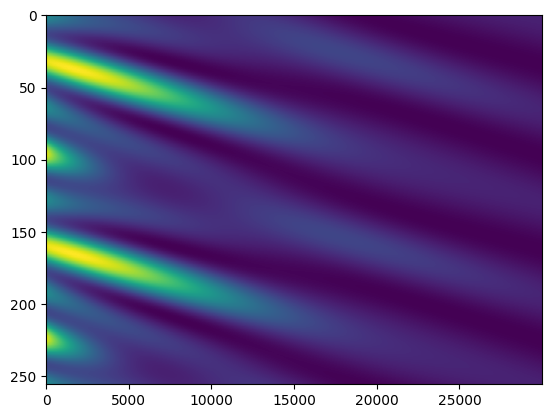

In [ ]:
plt.imshow(rout**2 + iout**2, aspect = 'auto')

In [ ]:
interval = 40
testr = torch.tensor(rout[:,::interval]).T
testi = torch.tensor(iout[:,::interval]).T
data_y = torch.cat((testr[:,:,None], testi[:,:,None]), dim=-1)
data_y.shape

torch.Size([750, 256, 2])

In [ ]:
t_data = dt*torch.arange(data_y.shape[0]).view(-1)
x_data  = torch.linspace(0,2*torch.pi,N)
x_grid, t_grid = torch.meshgrid(x_data, t_data, indexing='ij')
x_grid = x_grid.T[:,:,None].requires_grad_(True) #Agregamos una dimensión al final para que pueda ser input de la red
t_grid = t_grid.T[:,:,None].requires_grad_(True) #Agregamos una dimensión al final para que pueda ser input de la red
input_data = torch.cat((x_grid, t_grid), dim=-1)
input_data.shape

torch.Size([750, 256, 2])

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
dataset = TensorDataset(input_data, data_y)

In [ ]:
batch_size = 10
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class MLP(torch.nn.Module):
    """
    Multilayer perceptron (MLP) // Perceptríon Multicapa .

    Esta clase define una red neuronal feedforward con múltiples capas ocultas
    lineales, funciones de activación tangente hiperbólica en  las capas ocultas
    y una salida lineal.

    Args:
        sizes (lista): Lista de enteros que especifica el número de neuronas en
        cada capa. El primer elemento debe coincidir con la dimensión de entrada
        y el último con la dimensión de salida.

    Atributos:
        capas (torch.nn.ModuleList): Lista que contiene las capas lineales del MLP.

    Métodos:
        forward(x): Realiza una pasada hacia adelante a través de la red MLP.

    Ejemplo:
        tamaños = [entrada_dim, oculta1_dim, oculta2_dim, salida_dim]
        mlp = MLP(tamaños)
        tensor_entrada = torch.tensor([...])
        salida = mlp(tensor_entrada)
    """
    def __init__(self,sizes):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        self.p1  = torch.nn.Parameter(data=torch.rand(1), requires_grad=True)
        self.p2  = torch.nn.Parameter(data=torch.rand(1), requires_grad=True)
        self.p3  = torch.nn.Parameter(data=torch.rand(1), requires_grad=True)
        self.p4  = torch.nn.Parameter(data=torch.rand(1), requires_grad=True)
        self.p5  = torch.nn.Parameter(data=torch.rand(1), requires_grad=True)
        self.p6  = torch.nn.Parameter(data=torch.rand(1), requires_grad=True)
        self.a   = torch.nn.Parameter(data=torch.rand(1), requires_grad=True) #for improved convergence
        for i in range(len(sizes)-1):
            self.layers.append(torch.nn.Linear(sizes[i],sizes[i+1]))
    def forward(self,x):
        h = x
        for hidden in self.layers[:-1]:
            h = torch.tanh(hidden(h))
        output = self.layers[-1]
        y = output(h)
        return y

In [ ]:
#Generating the data
interval = 40
testr = torch.tensor(rout[:,::interval]).T
testi = torch.tensor(iout[:,::interval]).T
data_y = torch.cat((testr[:,:,None], testi[:,:,None]), dim=-1)

#t_data = dt*torch.arange(data_y.shape[0]).view(-1)
#x_data  = torch.linspace(0,2*torch.pi,N)
t_data = torch.linspace(-1,1,data_y.shape[0]).view(-1)
x_data  = torch.linspace(-1,1,N)
x_grid, t_grid = torch.meshgrid(x_data, t_data, indexing='ij')
x_grid = x_grid.T[:,:,None].requires_grad_(True) #Agregamos una dimensión al final para que pueda ser input de la red
t_grid = t_grid.T[:,:,None].requires_grad_(True) #Agregamos una dimensión al final para que pueda ser input de la red
input_data = torch.cat((x_grid, t_grid), dim=-1)

from torch.utils.data import TensorDataset, DataLoader
dataset = TensorDataset(input_data.to(torch.float32), data_y.to(torch.float32))

batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
#Defining the network
pinn = MLP([2] + [128]*6 +[2])
optimizer = torch.optim.Adam(pinn.parameters(),lr=1e-4)
lossfun = torch.nn.MSELoss()

In [ ]:
#Loop para el caso SIN FISICA
iterations = 15000 #Numero de iteraciones
l = 0.5   #Peso relativo lambda

for epoch in range(iterations):
    for input, target in dataloader:
      optimizer.zero_grad()
      #Asimilación de los datos
      yh    = pinn(input)
      loss = lossfun(target, yh)
      loss.backward()
      optimizer.step()
    with torch.autograd.no_grad():
      print(epoch,"\tTraning Loss:",float(loss.data))

0 	Traning Loss: 0.0014825188554823399
1 	Traning Loss: 0.001454775920137763
2 	Traning Loss: 0.0015811293851584196
3 	Traning Loss: 0.0017959479009732604
4 	Traning Loss: 0.001356984954327345
5 	Traning Loss: 0.0015650719869881868
6 	Traning Loss: 0.0015811786288395524
7 	Traning Loss: 0.0015481050359085202
8 	Traning Loss: 0.001527340617030859
9 	Traning Loss: 0.001640957547351718
10 	Traning Loss: 0.0017208292847499251
11 	Traning Loss: 0.0014912693295627832
12 	Traning Loss: 0.001593016437254846
13 	Traning Loss: 0.0016052876599133015
14 	Traning Loss: 0.0014339620247483253
15 	Traning Loss: 0.0014060410903766751
16 	Traning Loss: 0.0016980513464659452
17 	Traning Loss: 0.0018540907185524702
18 	Traning Loss: 0.001574179856106639
19 	Traning Loss: 0.0017983268480747938
20 	Traning Loss: 0.0015392906498163939
21 	Traning Loss: 0.001531289773993194
22 	Traning Loss: 0.001502437749877572
23 	Traning Loss: 0.001567191444337368
24 	Traning Loss: 0.0015377316158264875
25 	Traning Loss: 0

KeyboardInterrupt: ignored

In [ ]:
neural = pinn(input_data)
neural = (neural[:,:,0]**2 + neural[:,:,1]**2).detach().numpy()
numerical =(testr**2 + testi**2).detach().numpy()

In [ ]:
neural.shape

(750, 256)

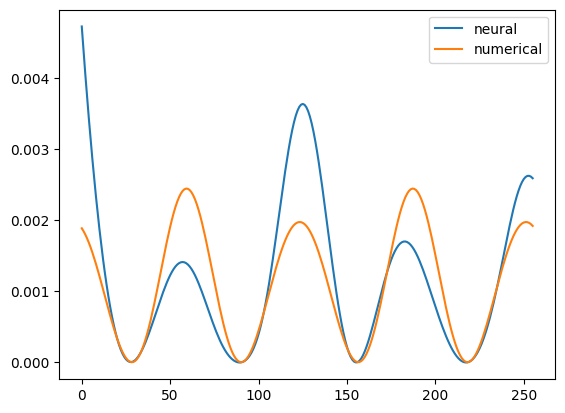

In [ ]:
plt.plot(neural[700,:], label = 'neural')
plt.plot(numerical[700,:], label = 'numerical')
plt.legend()

In [ ]:
iterations = 15000 #Numero de iteraciones
l = 0.5   #Peso relativo lambda

for epoch in range(iterations):
    optimizer.zero_grad()
    #Asimilación de los datos
    yh = pinn(input_data)               #Evalúo los datos que tengo de la simuación/medicion
    loss1 = torch.mean((yh-y_data)**2)  #Calculo el mean square error
    #Condiciones de la física sobre la misma grilla
    #Parte real
    dxr  = torch.autograd.grad(yh[:,:,0], x_grid, torch.ones_like(yh[:,:,0]), create_graph=True)[0]
    dxxr = torch.autograd.grad(dxr,        x_grid, torch.ones_like(dxr), create_graph=True)[0]
    dtr  = torch.autograd.grad(yh[:,:,0], t_grid, torch.ones_like(yh[:,:,0]), create_graph=True)[0]
    dxr  = dxr[:,:,0]
    dxxr = dxxr[:,:,0]
    dtr  = dtr[:,:,0]
    #Parte imaginaria
    dxi  = torch.autograd.grad(yh[:,:,1], x_grid, torch.ones_like(yh[:,:,1]), create_graph=True)[0]
    dxxi = torch.autograd.grad(dxi,        x_grid, torch.ones_like(dxi), create_graph=True)[0]
    dti  = torch.autograd.grad(yh[:,:,1], t_grid, torch.ones_like(yh[:,:,1]), create_graph=True)[0]
    dxi  = dxi[:,:,0]
    dxxi = dxxi[:,:,0]
    dti  = dti[:,:,0]
    #|A|²
    sqr  = yh[:,:,0]**2 + yh[:,:,1]**2
    ######################
    physicsr = dtr - pinn.p1*yh[:,:,0] + pinn.p2*dxr + pinn.p3*(dxxr - pinn.p4*dxxi) - pinn.p5*sqr*(yh[:,:,0] - pinn.p6*yh[:,:,1])
    physicsi = dti - pinn.p1*yh[:,:,1] + pinn.p2*dxi + pinn.p3*(dxxi + pinn.p4*dxxr) - pinn.p5*sqr*(yh[:,:,1] + pinn.p6*yh[:,:,0])
    physics  = physicsr + physicsi
    loss2 = l*torch.mean((physics)**2)   #MSE de la física
    loss = loss1 + loss2   #Sumamos todos los errores
    loss.backward()
    optimizer.step()
    with torch.autograd.no_grad():
    	print(epoch,'Data',float(loss1), 'PDE',float(loss2), float(pinn.p1),float(pinn.p1),float(pinn.p2),float(pinn.p3), float(pinn.p4),float(pinn.p5),float(pinn.p6) ,"\tTraning Loss:",float(loss.data))

0 Data 0.0322575367088622 PDE 0.03149552643299103 0.15227869153022766 0.15227869153022766 0.1451098471879959 0.030656570568680763 0.5409872531890869 0.9537032246589661 0.611669659614563 	Traning Loss: 0.06375306314185322
1 Data 0.014038805614384678 PDE 0.037308476865291595 0.1522040069103241 0.1522040069103241 0.14499638974666595 0.03063681721687317 0.5410025119781494 0.9535953402519226 0.6118128299713135 	Traning Loss: 0.05134728247967627
2 Data 0.012212067823535186 PDE 0.038901329040527344 0.15213678777217865 0.15213678777217865 0.14495442807674408 0.03059501387178898 0.5409716963768005 0.9535025358200073 0.6119397282600403 	Traning Loss: 0.05111339686406253
3 Data 0.02021967920108749 PDE 0.03986791521310806 0.15206646919250488 0.15206646919250488 0.14499293267726898 0.030518149957060814 0.5409042239189148 0.9534210562705994 0.6120526790618896 	Traning Loss: 0.060087594414195554
4 Data 0.03245556635041352 PDE 0.041349392384290695 0.1519859880208969 0.1519859880208969 0.14509816467761

KeyboardInterrupt: ignored

In [ ]:
pinn.a

Parameter containing:
tensor([0.6598], requires_grad=True)

In [ ]:
val = yh[:,:,0].detach().numpy()**2 + yh[:,:,1].detach().numpy()**2
valo = y_data[:,:,0].detach().numpy()**2 + y_data[:,:,1].detach().numpy()**2

In [ ]:
val.shape

(256, 300)

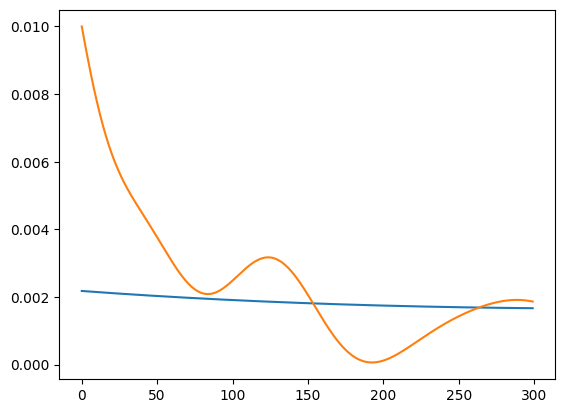

In [ ]:
plt.plot(val[0,:])
plt.plot(valo[0,:])

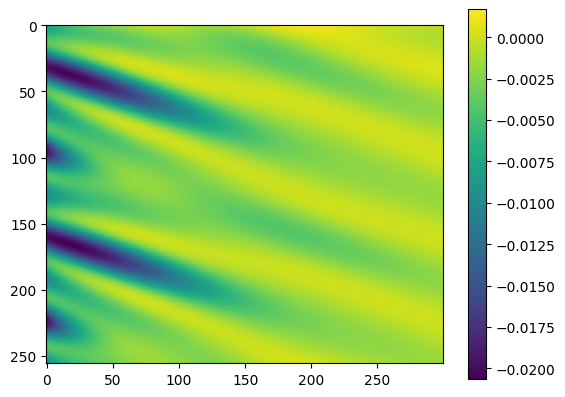

In [ ]:
plt.imshow(val-valo)
plt.colorbar()

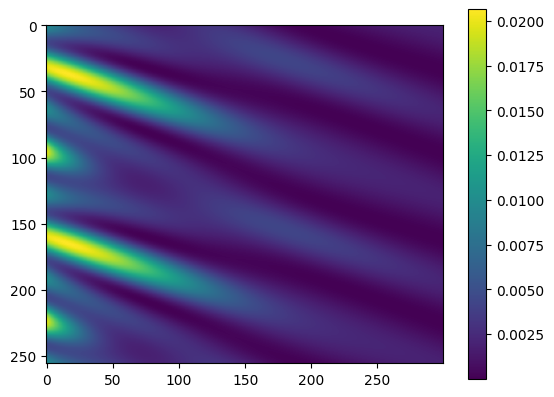

In [ ]:
plt.imshow(valo)
plt.colorbar()

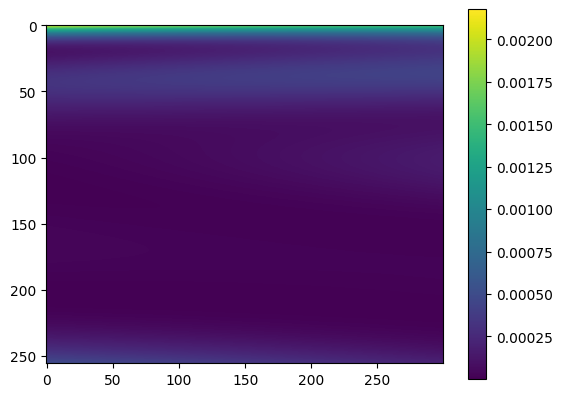

In [ ]:
plt.imshow(val)
plt.colorbar()

In [ ]:
# VERSION VIEJA DE CARGAR LOS DATOS, SIN DATALOADER
interval = 100
real_cutted     = rout
imag_cutted     = iout
real_data = torch.from_numpy(real_cutted[:,::interval])[:,:,None]
imag_data = torch.from_numpy(imag_cutted[:,::interval])[:,:,None]
y_data = torch.cat((real_data,imag_data),dim = -1)

t_data = (interval*dt*torch.arange(steps//interval+1)).view(-1)
x_data  = torch.linspace(0,2*torch.pi,N)
x_grid, t_grid = torch.meshgrid(x_data, t_data, indexing='ij')
x_grid = x_grid[:,:,None].requires_grad_(True) #Agregamos una dimensión al final para que pueda ser input de la red
t_grid = t_grid[:,:,None].requires_grad_(True) #Agregamos una dimensión al final para que pueda ser input de la red
input_data = torch.cat((x_grid, t_grid), dim=-1)